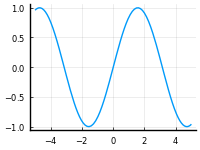

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall D:\.julia\packages\PyCall\3fwVL\src\numpy.jl:67


In [1]:
using Distributions
using StatsPlots
using Memoization
using StatsBase: ecdf
using StatsFuns: xlogy

x ⪅ y = x < y || x ≈ y    # \lessapprox
x ⪆ y = y ⪅ x             # \gtrapprox
x ⪉ y = x < y && !(x ≈ y) # \lnapprox
x ⪊ y = y ⪉ x             # \gnapprox

safemul(x, y) = x == 0 ? zero(float(typeof(x))) : x * y
safediv(x, y) = x == 0 ? zero(float(typeof(x))) : x / y

pyplot()
default(fmt=:png, size=(400, 300), titlefontsize=10, tickfontsize=6)
plot(sin; size=(200, 150), label="")

In [2]:
pdfbin(r, s, p, q, x, y) = pdf(Binomial(r, p), x) * pdf(Binomial(s, q), y)
supportbin(r, s) = Iterators.product(0:r, 0:s)
prob_rejection(testfunc, α, r, s, p, q) = 
    sum(pdfbin(r, s, p, q, a, c) * testfunc(a, r-a, c, s-c; α) for (a, c) in supportbin(r, s))

prob_rejection (generic function with 1 method)

In [3]:
function chisqstat(a, b, c, d)
    s, f, m ,n = a + b, c + d, a + c, b + d
    safediv((a*d - b*c)^2 * (m + n), s * f * m * n)
end
chisqstat(A) = chisqstat(A...)

@memoize pval_chisq(a, b, c, d) = ccdf(Chisq(1), chisqstat(a, b, c, d))
pval_chisq(A) = pval_chisq(A...)

test_chisq(a, b, c, d; α = 0.05) = float(pval_chisq(a, b, c, d) < α)
test_chisq(A; α = 0.05) = test_chisq(A...; α)

test_chisq (generic function with 2 methods)

In [4]:
function gstat(a, b, c, d)
    s, f, m ,n = a + b, c + d, a + c, b + d
    N = m + n
    sum_of_xlogx_data = xlogy(a, a) + xlogy(b, b) + xlogy(c, c) + xlogy(d, d)
    sum_of_xlogx_margin = xlogy(s, s) + xlogy(f, f) + xlogy(m, m) + xlogy(n, n)
    2(sum_of_xlogx_data - sum_of_xlogx_margin + xlogy(N, N))
end
gstat(A) = gstat(A...)

@memoize pval_g(a, b, c, d) = ccdf(Chisq(1), gstat(a, b, c, d))
pval_g(A) = pval_g(A...)

test_g(a, b, c, d; α = 0.05) = float(pval_g(a, b, c, d) < α)
test_g(A; α = 0.05) = test_g(A...; α)

test_g (generic function with 2 methods)

https://en.wikipedia.org/wiki/G-test: In cases where $O_{i}>2\cdot E_{i}$ for some cell case the G-test is always better than the chi-squared test \[citation needed\]

In [5]:
function pval_mixed(a, b, c, d)
    s, f, m ,n = a + b, c + d, a + c, b + d
    N = s + f
    ã, b̃, c̃, d̃ = s*m/N, s*n/N^2, f*m/N, f*n/N
    if a > 2ã || b > 2b̃ || c > 2c̃ || d > 2d̃
        pval_g(a, b, c, d)
    else
        pval_chisq(a, b, c, d)
    end
end
pval_mixed(A) = pval_mexed(A...)

test_mixed(a, b, c, d; α = 0.05) = float(pval_mixed(a, b, c, d) < α)
test_mixed(A; α = 0.05) = test_mixed(A...; α)

test_mixed (generic function with 2 methods)

In [6]:
function plot_realalphas(; r = 10, s = 20, p = 0.4, q = p, kwargs...)
    α = 0:0.005:1.005
    xtick = ytick = 0:0.1:1
    A = prob_rejection.(test_chisq, α, r, s, p, q)
    B = prob_rejection.(test_mixed, α, r, s, p, q)
    C = prob_rejection.(test_g, α, r, s, p, q)    
    P = plot(; legend=:topleft, xtick, ytick)
    plot!(α, A; label="chisq")
    plot!(α, B; label="mixed", ls=:dash)
    plot!(α, C; label="g", ls=:dashdot)
    plot!([0, 1.005], [0, 1.005]; label="", c=:black, ls=:dot, lw=0.5)
    
    α = 0:0.0005:0.1
    xtick = ytick = 0:0.01:1
    A = prob_rejection.(test_chisq, α, r, s, p, q)
    B = prob_rejection.(test_mixed, α, r, s, p, q)
    C = prob_rejection.(test_g, α, r, s, p, q)    
    Q = plot(; legend=:topleft, xtick, ytick)
    plot!(α, A; label="chisq")
    plot!(α, B; label="mixed", ls=:dash)
    plot!(α, C; label="g", ls=:dashdot)
    plot!([0, 0.1], [0, 0.1]; label="", c=:black, ls=:dot, lw=0.5)
    
    plot(P, Q; size=(600, 300), layout=(1, 2))
    plot!(; kwargs...)
end

plot_realalphas (generic function with 1 method)

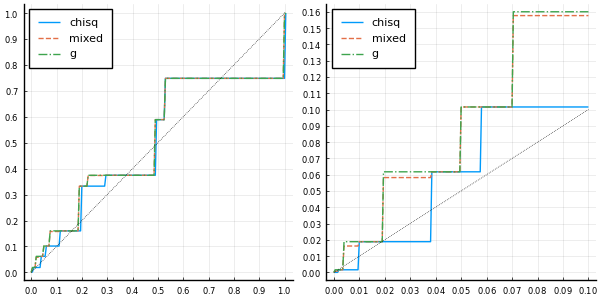

In [7]:
plot_realalphas(; r=5, s=5, p=0.4)

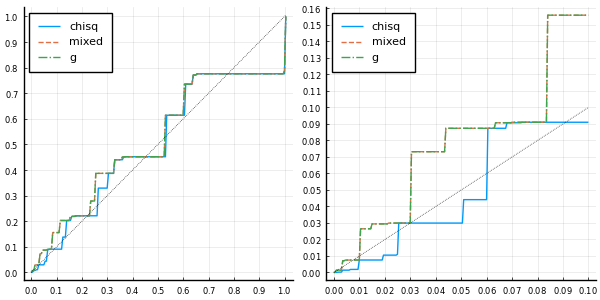

In [8]:
plot_realalphas(; r=10, s=10, p=0.2)

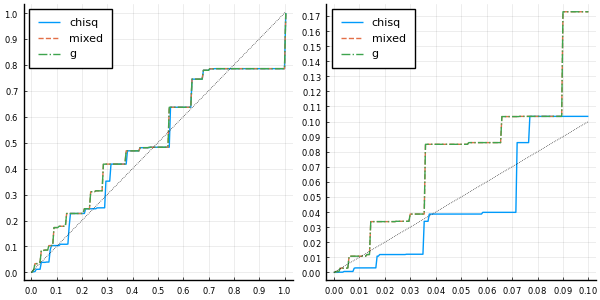

In [9]:
plot_realalphas(; r=20, s=20, p=0.1)

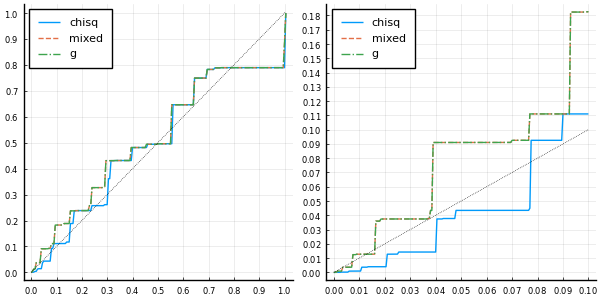

In [10]:
plot_realalphas(; r=40, s=40, p=0.05)

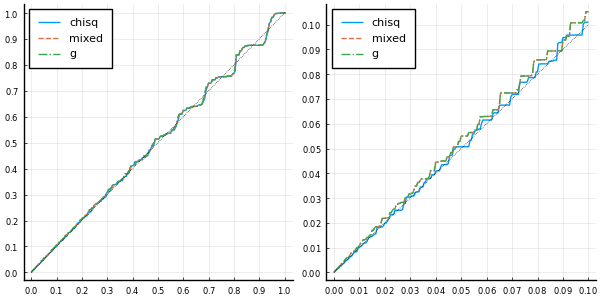

In [11]:
plot_realalphas(; r=34, s=66, p=0.28)

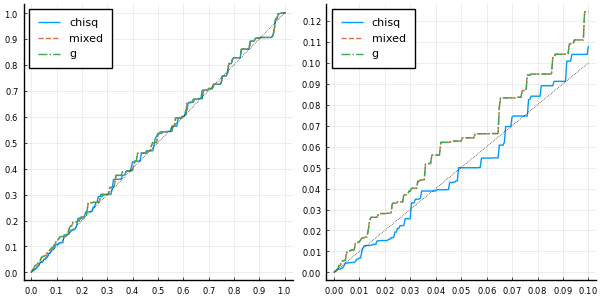

In [12]:
plot_realalphas(; r=34, s=66, p=0.1)

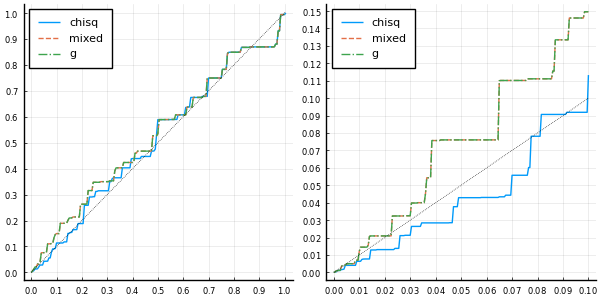

In [13]:
plot_realalphas(; r=34, s=66, p=0.05)

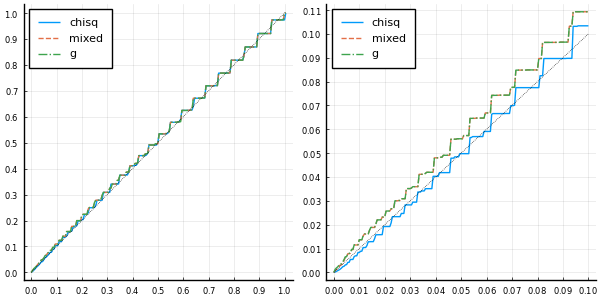

In [14]:
plot_realalphas(; r=10, s=90, p=0.5)

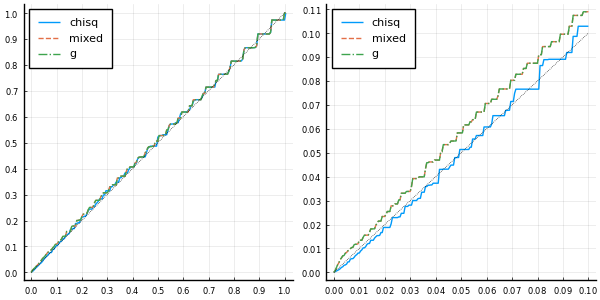

In [15]:
plot_realalphas(; r=10, s=90, p=0.4)

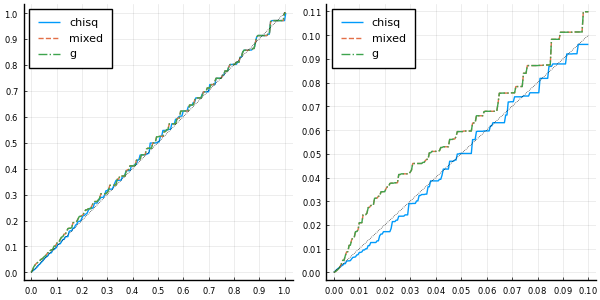

In [16]:
plot_realalphas(; r=10, s=90, p=0.3)

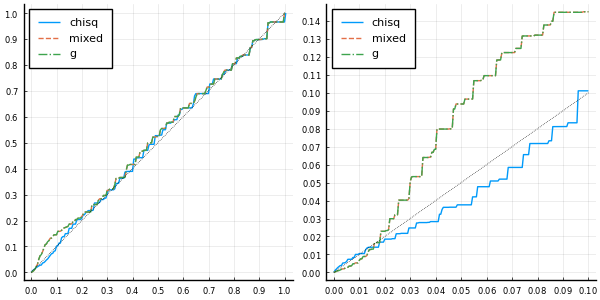

In [17]:
plot_realalphas(; r=10, s=90, p=0.2)

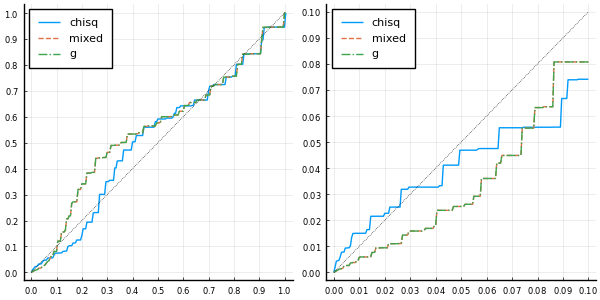

In [18]:
plot_realalphas(; r=10, s=90, p=0.1)

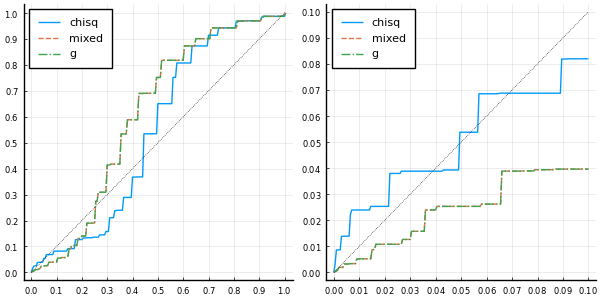

In [19]:
plot_realalphas(; r=10, s=90, p=0.05)

In [20]:
function plot_powers(; α = 0.05, r = 10, s = 20,
        levels = [0.0:0.4α:2α; 0.2:0.2:1], kwargs...)
    p = q = 0:0.01:1
    xtick = ytick = 0:0.1:1
    
    A = prob_rejection.(test_chisq, α, r, s, p', q)
    B = prob_rejection.(test_mixed, α, r, s, p', q)
    C = prob_rejection.(test_g, α, r, s, p', q)
    
    P = contour(p, q, A; clim=(0, 1), title="power of chisq", levels, xtick, ytick)
    Q = contour(p, q, B; clim=(0, 1), title="power of mixed", levels, xtick, ytick)
    R = contour(p, q, C; clim=(0, 1), title="power of g", levels, xtick, ytick)
    
    AB = @. log2(B) - log2(A)
    AC = @. log2(C) - log2(A)
    BC = @. log2(C) - log2(B)
    
    PQ = heatmap(p, q, AB; clim=(-1, 1), c=:bwr, title="power: chisq b-w-r mixed", xtick, ytick)
    PR = heatmap(p, q, AC; clim=(-1, 1), c=:bwr, title="power: chisq b-w-r g", xtick, ytick)
    QR = heatmap(p, q, BC; clim=(-1, 1), c=:bwr, title="power: mixed b-w-r g", xtick, ytick)

    plot(P, Q, R, PQ, PR, QR; size=(800, 560), layout=(2, 3),
        colorbar=false, contour_labels=true)
    plot!(; kwargs...)
end

plot_powers (generic function with 1 method)

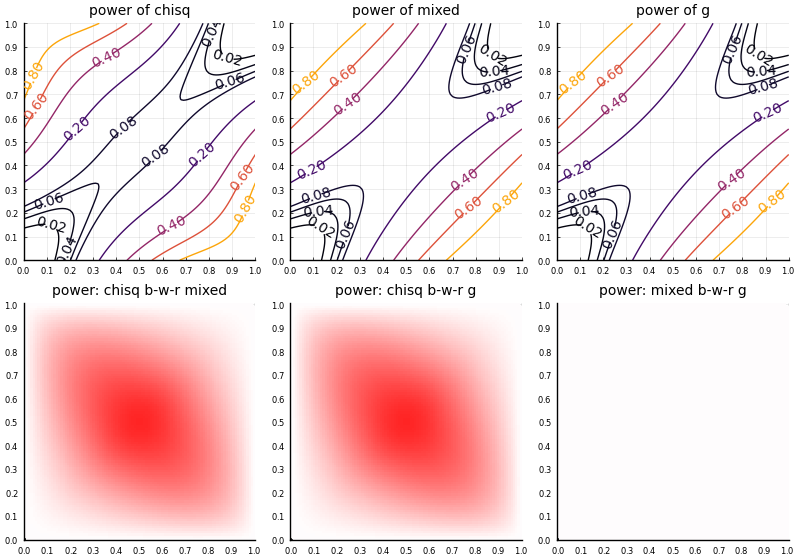

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [21]:
plot_powers(; r = 5, s = 5)

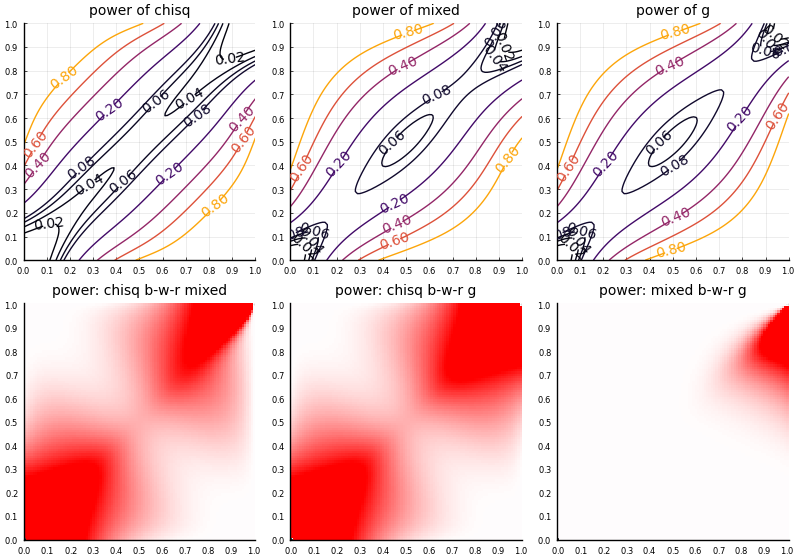

In [22]:
plot_powers(; r = 10, s = 10)

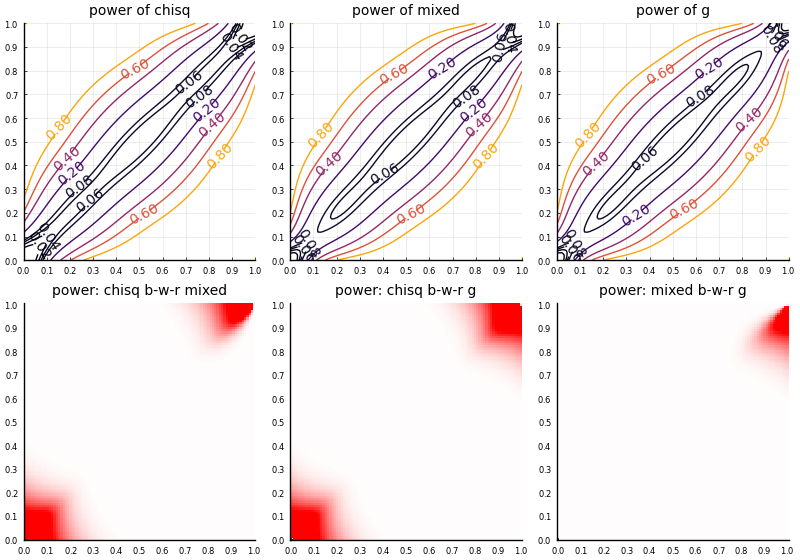

In [23]:
plot_powers(; r = 20, s = 20)

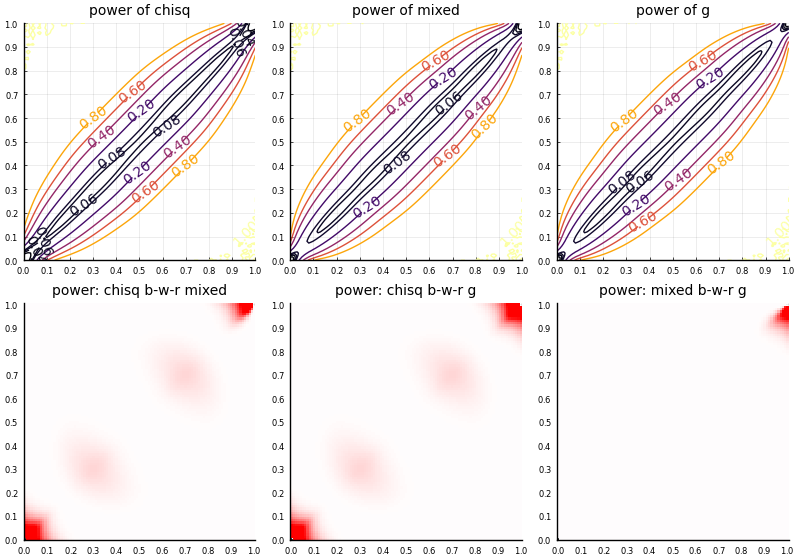

In [24]:
plot_powers(; r = 40, s = 40)

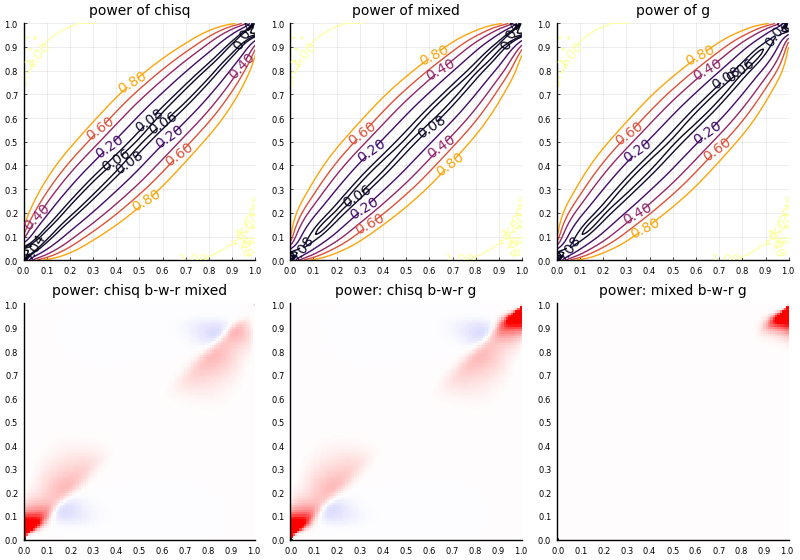

In [25]:
plot_powers(; r = 34, s = 66)

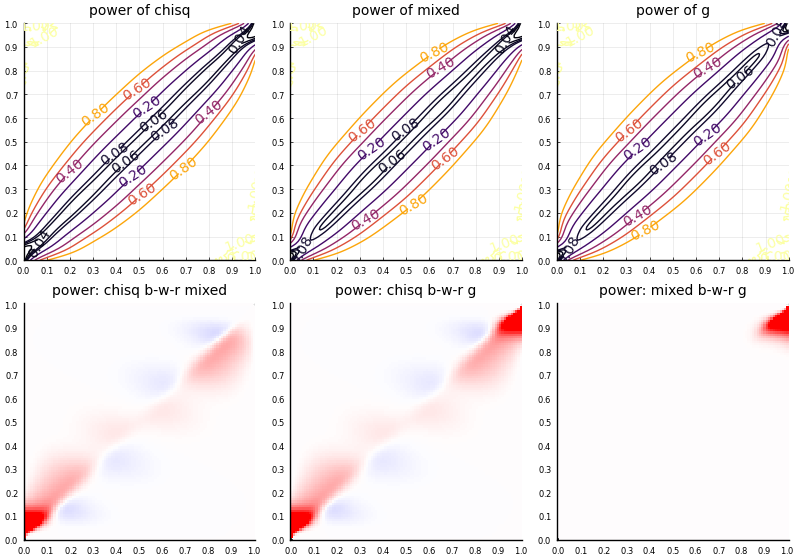

In [26]:
plot_powers(; r = 28, s = 72)

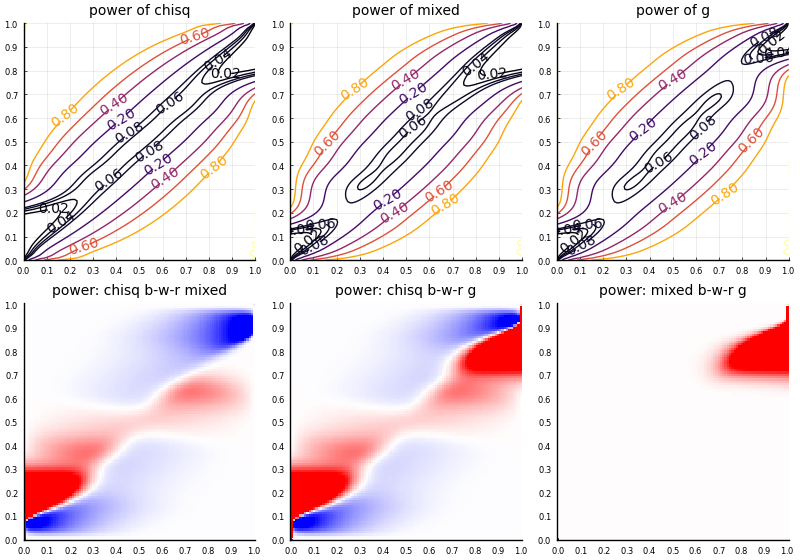

In [27]:
plot_powers(; r = 10, s = 90)